In [1]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from trustyai.model import Model, feature, output, feature_domain
from trustyai.explainers import CounterfactualExplainer, LimeExplainer, SHAPExplainer
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xgboost
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


# Toy example

In [2]:
X, y = make_blobs(n_samples=2000, n_features=2, random_state=0, centers=[(-5,0), (0, 5), (5, 0)])

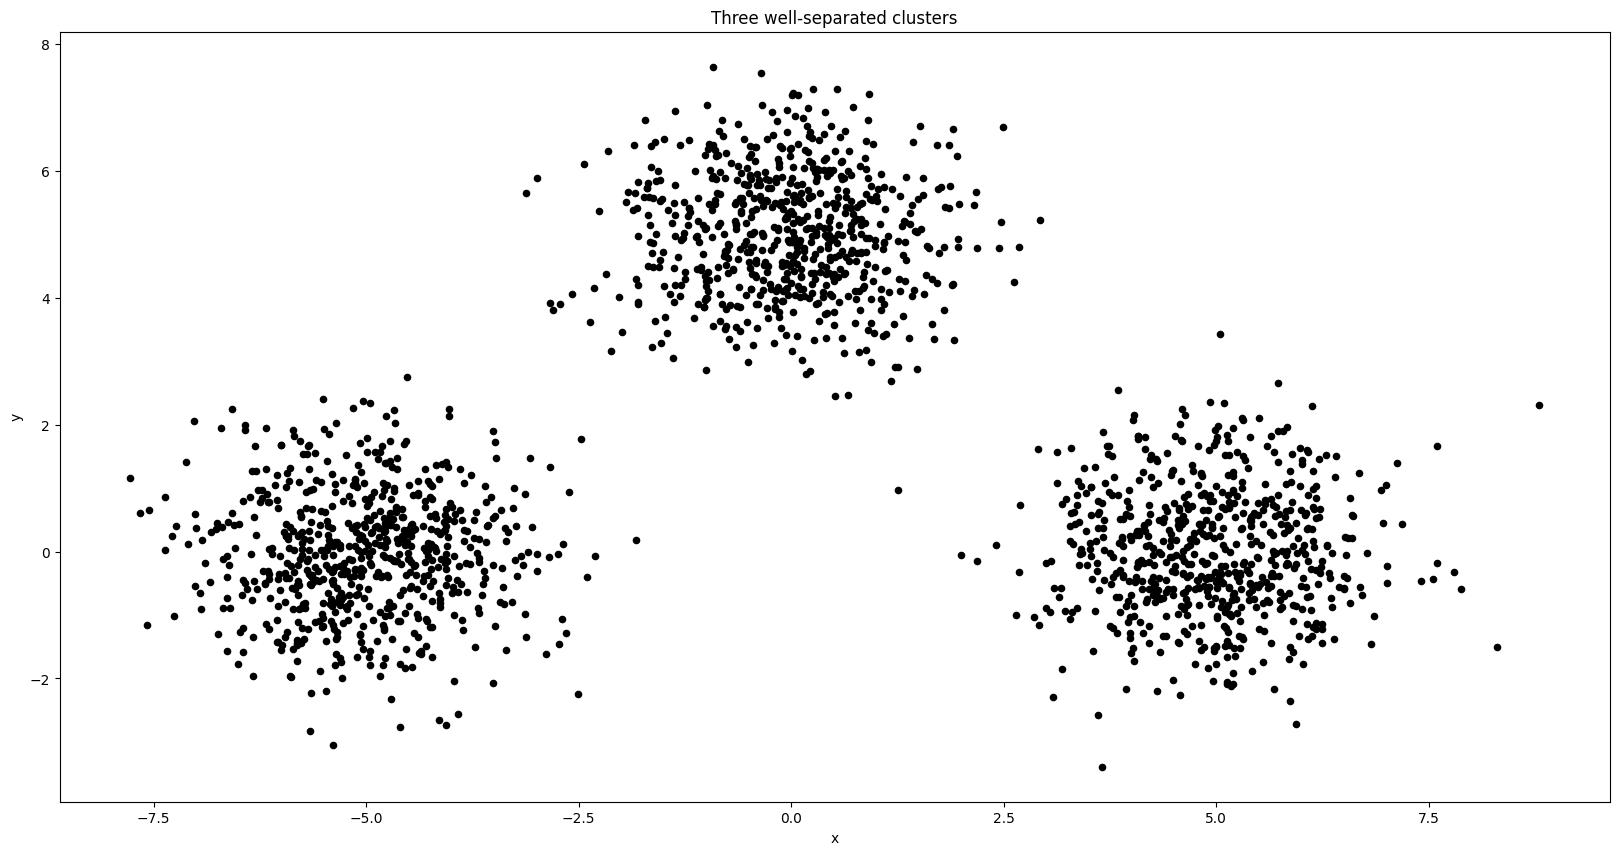

In [3]:
plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c='k', s=20)
plt.title("Three well-separated clusters")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [4]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X,y)

KNeighborsClassifier(n_neighbors=3)

In [5]:
predictions = knn.predict(X)

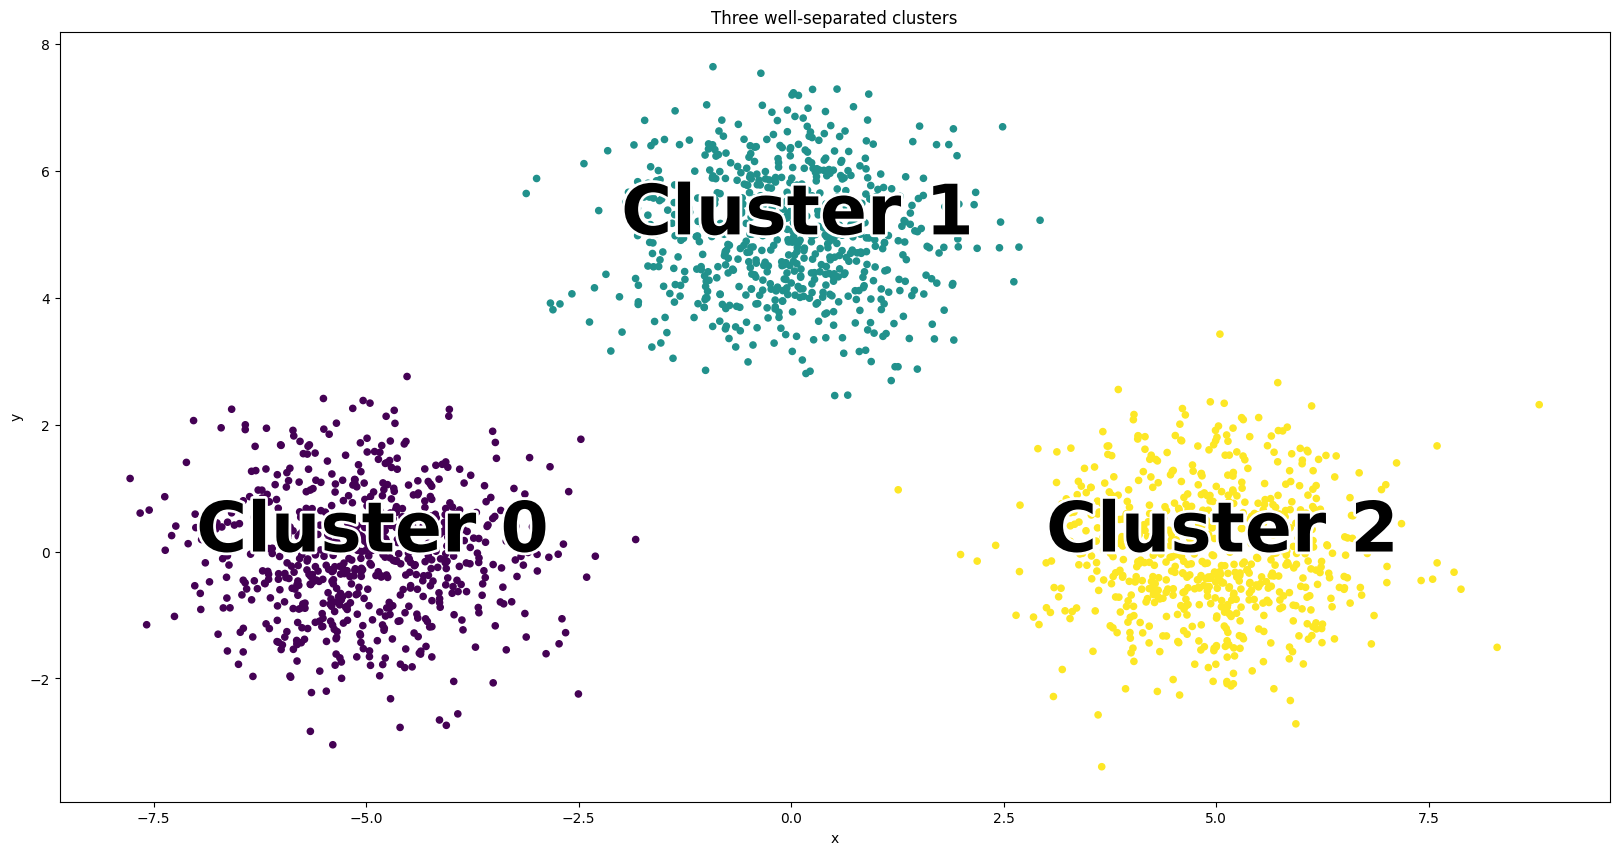

In [6]:
import matplotlib.patheffects as pe

plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c=predictions, s=20)
plt.annotate("Cluster 0", [-7, 0], fontsize=50, weight="bold", 
            color="k",
            path_effects=[pe.withStroke(linewidth=4, foreground="white")])
plt.annotate("Cluster 1", [-2, 5], fontsize=50, weight="bold", 
            color="k",
            path_effects=[pe.withStroke(linewidth=4, foreground="white")])
plt.annotate("Cluster 2", [3, 0], fontsize=50, weight="bold", 
            color="k",
            path_effects=[pe.withStroke(linewidth=4, foreground="white")])
plt.title("Three well-separated clusters")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [7]:
P = np.array([[2.5, -1.0]])

In [8]:
cluster = knn.predict(P)
print(f"Point P ({P}) classified as in cluster {cluster}")

Point P ([[ 2.5 -1. ]]) classified as in cluster [2]


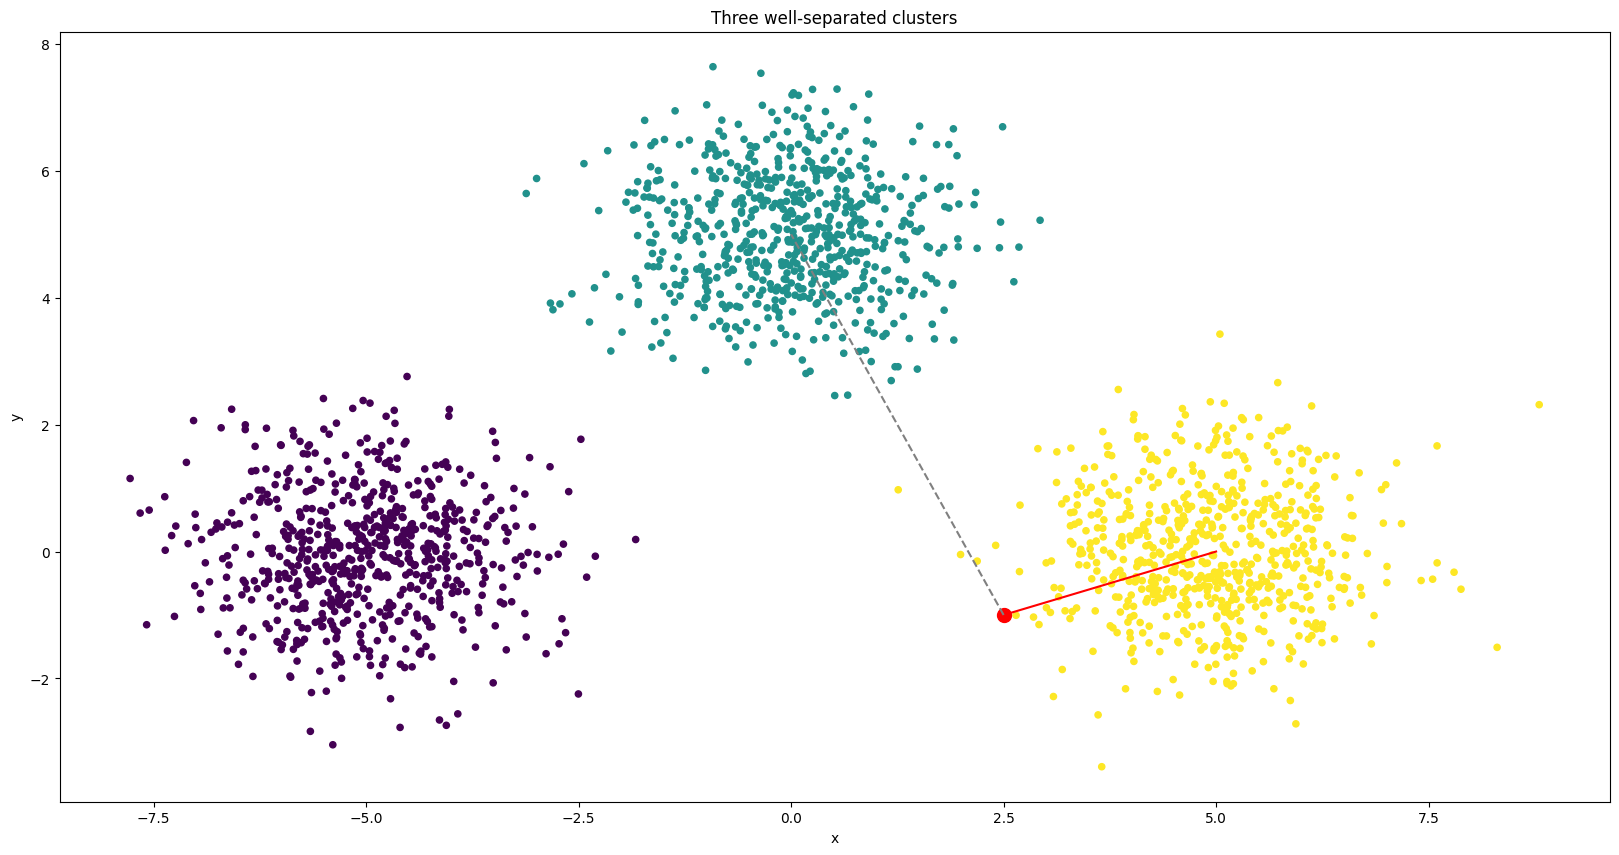

In [9]:
plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c=predictions, s=20)
plt.scatter(P[0][0], P[0][1], c="red", s=100)
plt.plot([P[0][0], 5], [P[0][1], 0], c="red")
plt.plot([P[0][0], 0], [P[0][1], 5], c="grey", linestyle="dashed")
plt.title("Three well-separated clusters")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Counterfactuals

In [10]:
model = Model(knn.predict, output_names=['cluster'])

In [11]:
from trustyai.model import output

goal = [output(name="cluster", dtype="number", value=1)]

In [12]:
features = [
    feature("x", "number", P[0][0], (-10, 10)), 
    feature("y", "number", P[0][1], (-10, 10))
]

In [13]:
counterfactual = CounterfactualExplainer(steps=10_000)

In [14]:
explanation = counterfactual.explain(inputs=features, goal=goal, model=model)

In [15]:
cf_P = explanation.proposed_features_array
cf_P

array([[2.49380669, 2.46489674]])

In [16]:
prediction = model(cf_P)
print(f"Point cf_p ({cf_P}) belongs in cluster {prediction}")

Point cf_p ([[2.49380669 2.46489674]]) belongs in cluster [1]


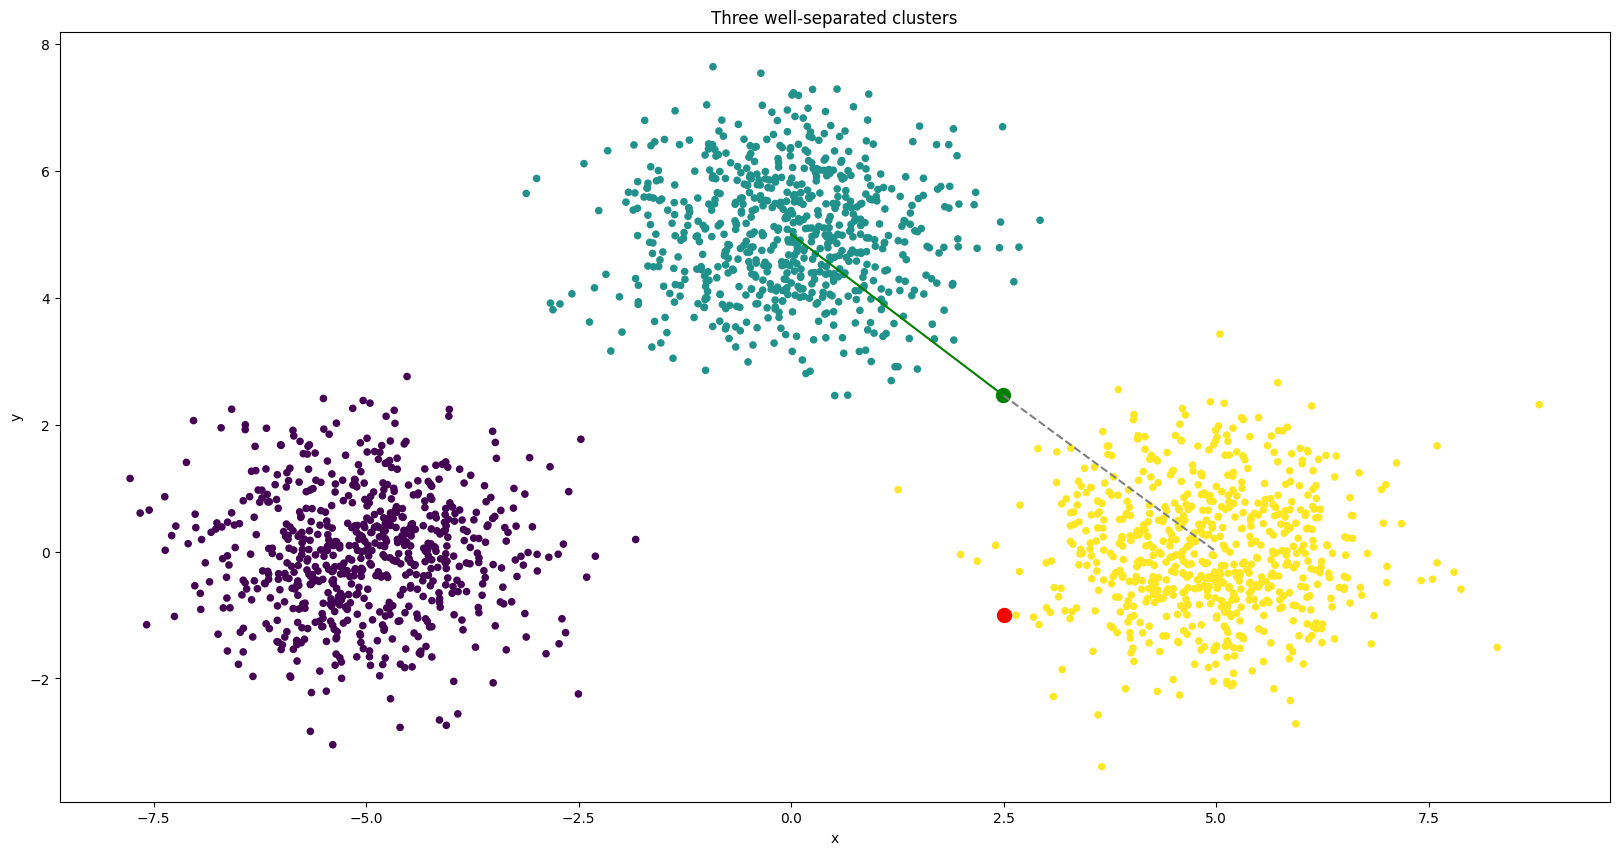

In [17]:
plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c=predictions, s=20)
plt.scatter(P[0][0], P[0][1], c="red", s=100)
plt.scatter(cf_P[0][0], cf_P[0][1], c="green", s=100)
plt.plot([cf_P[0][0], 5], [cf_P[0][1], 0], c="grey", linestyle="dashed")
plt.plot([cf_P[0][0], 0], [cf_P[0][1], 5], c="green")
plt.title("Three well-separated clusters")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [18]:
explanation.as_dataframe()

,features,proposed,original,constrained,difference
0,x,2.493807,2.5,False,-0.006193
1,y,2.464897,-1.0,False,3.464897


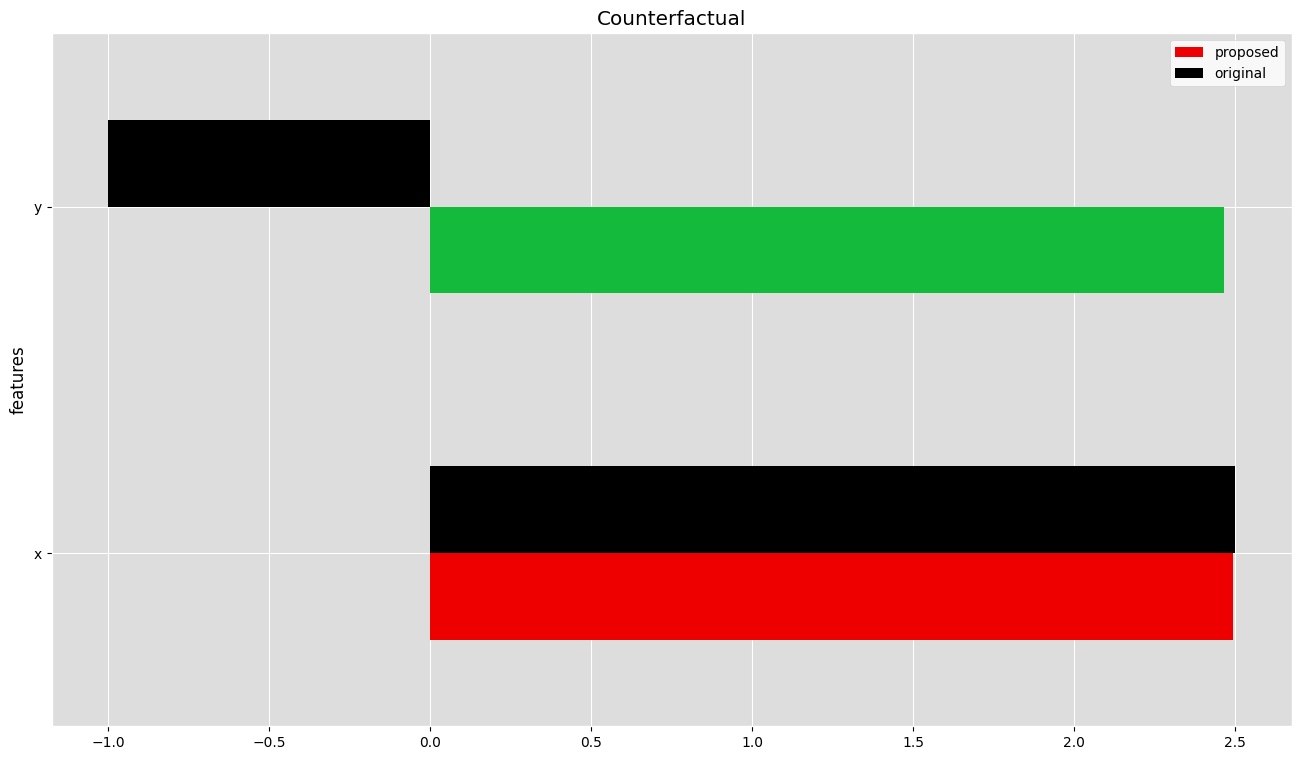

In [19]:
explanation.plot()

## LIME

In [20]:
lime = LimeExplainer(samples=100)

In [21]:
explanation = lime.explain(inputs=cf_P, outputs=prediction, model=model)

In [22]:
explanation.as_dataframe()['cluster']

,Feature,Value,Saliency,Confidence
0,input-0,2.493807,0.830195,0.0
1,input-1,2.464897,0.904046,0.0


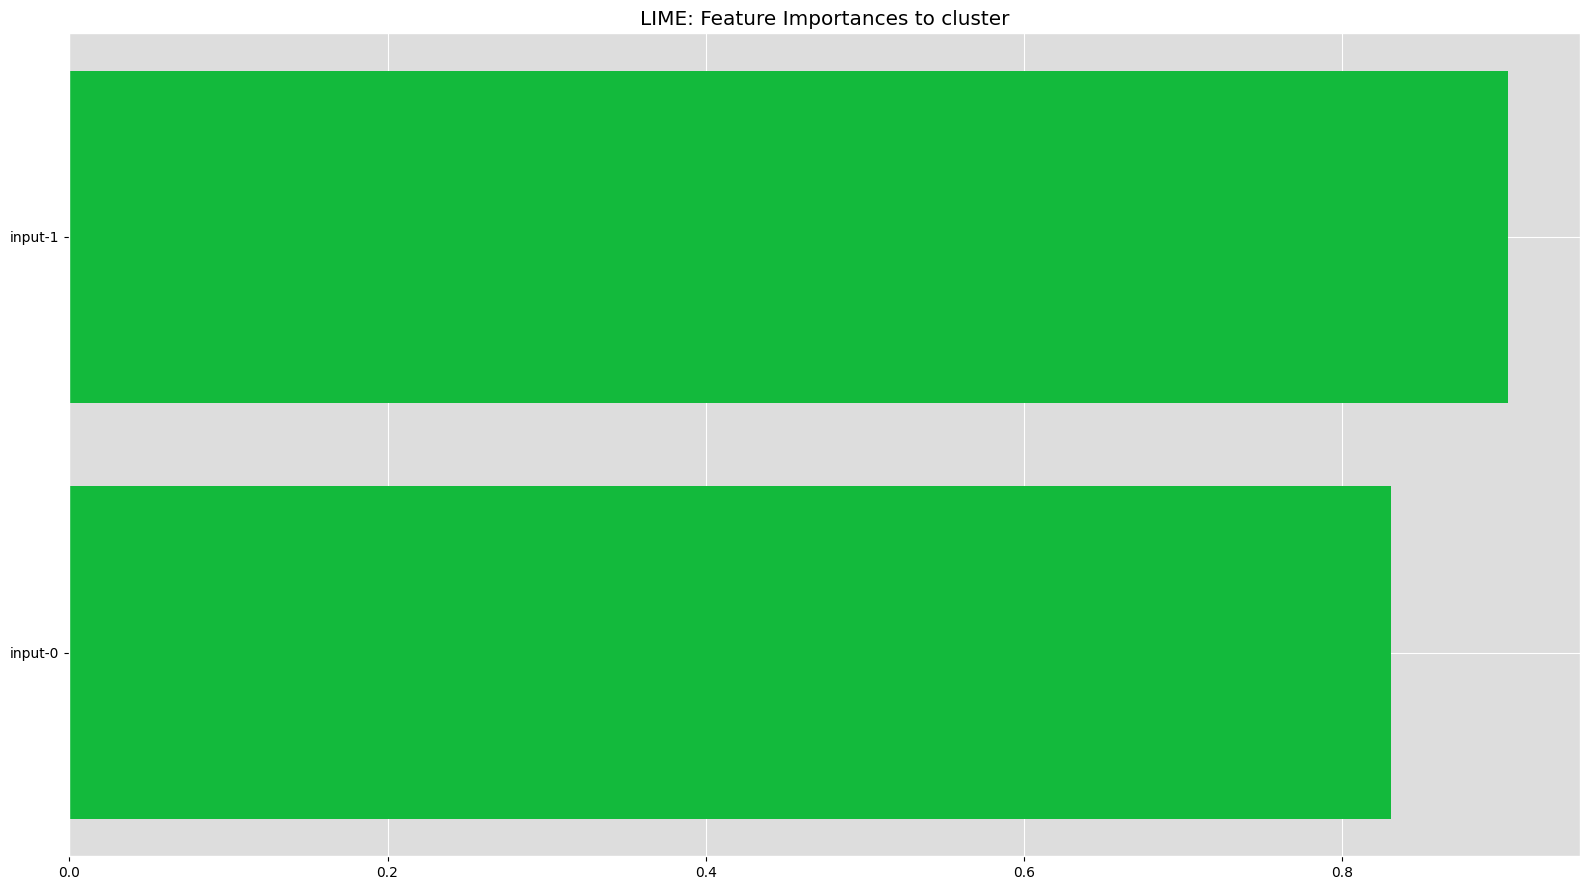

In [23]:
explanation.plot("cluster")

## SHAP

In [24]:
shap = SHAPExplainer(background=X[:100])

In [25]:
explanations = shap.explain(inputs=cf_P, 
                                 outputs=prediction,
                                 model=model)

In [26]:
explanations.as_html()['cluster']

,Feature,Value,Mean Background Value,SHAP Value,Confidence
0,Background,nan,nan,1.050000,nan
1,input-0,2.493807,0.184174,0.205000,3.494206
2,input-1,2.464897,2.428870,-0.255000,3.494206


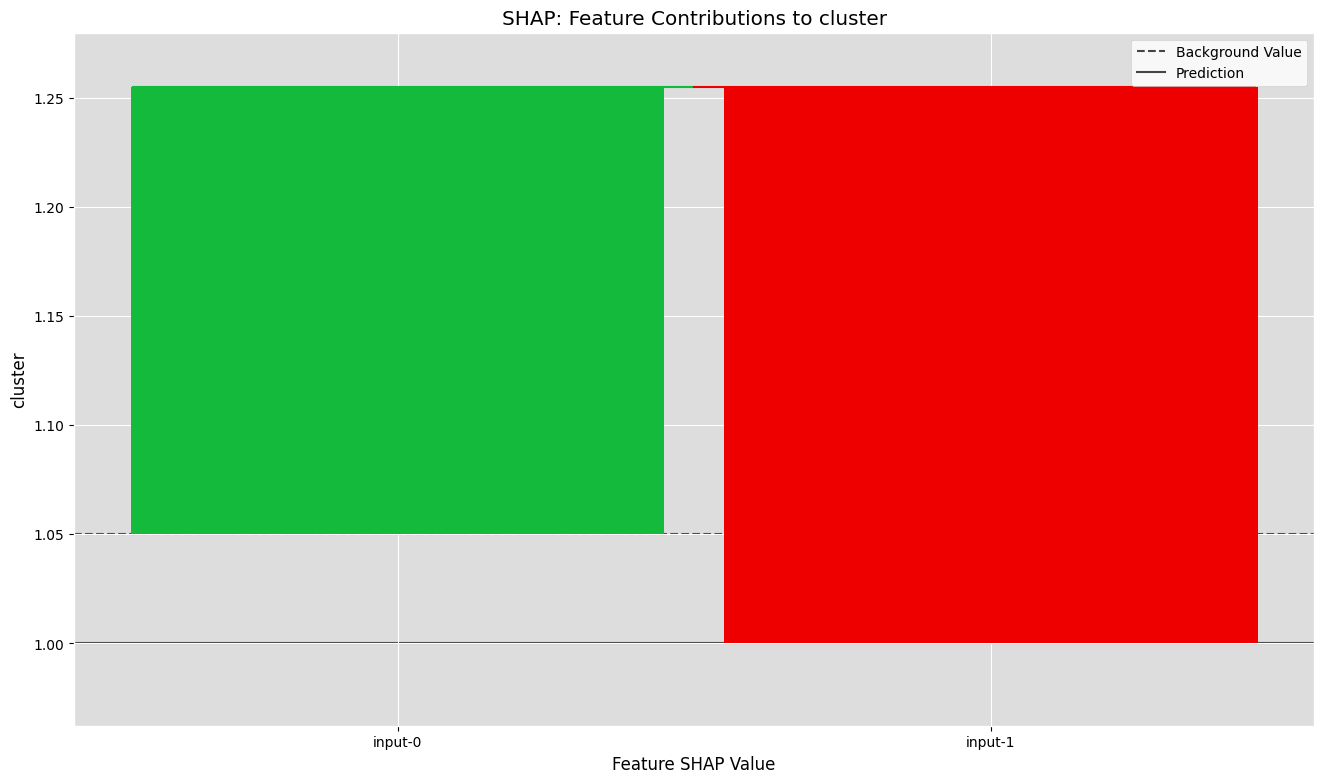

In [27]:
explanations.plot()

# Python model

In [28]:
X, y = datasets.fetch_california_housing(data_home="data", return_X_y=True, as_frame=True)
y = pd.DataFrame(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
print(f"X Train: {X_train.shape}, X Test: {X_test.shape}, Y Train: {y_train.shape}, Y Test: {y_test.shape}")


X Train: (16512, 8), X Test: (4128, 8), Y Train: (16512, 1), Y Test: (4128, 1)


In [29]:
xgb_model = xgboost.XGBRegressor(objective='reg:squarederror')
xgb_model.load_model("models/california_xgboost")
print('Test MSE', xgb_model.score(X_test, y_test))

Test MSE 0.9241791067818088


In [30]:
predictions = xgb_model.predict(X_test)

In [31]:
worst = np.argmax(np.abs(predictions - y_test['MedHouseVal'].values))

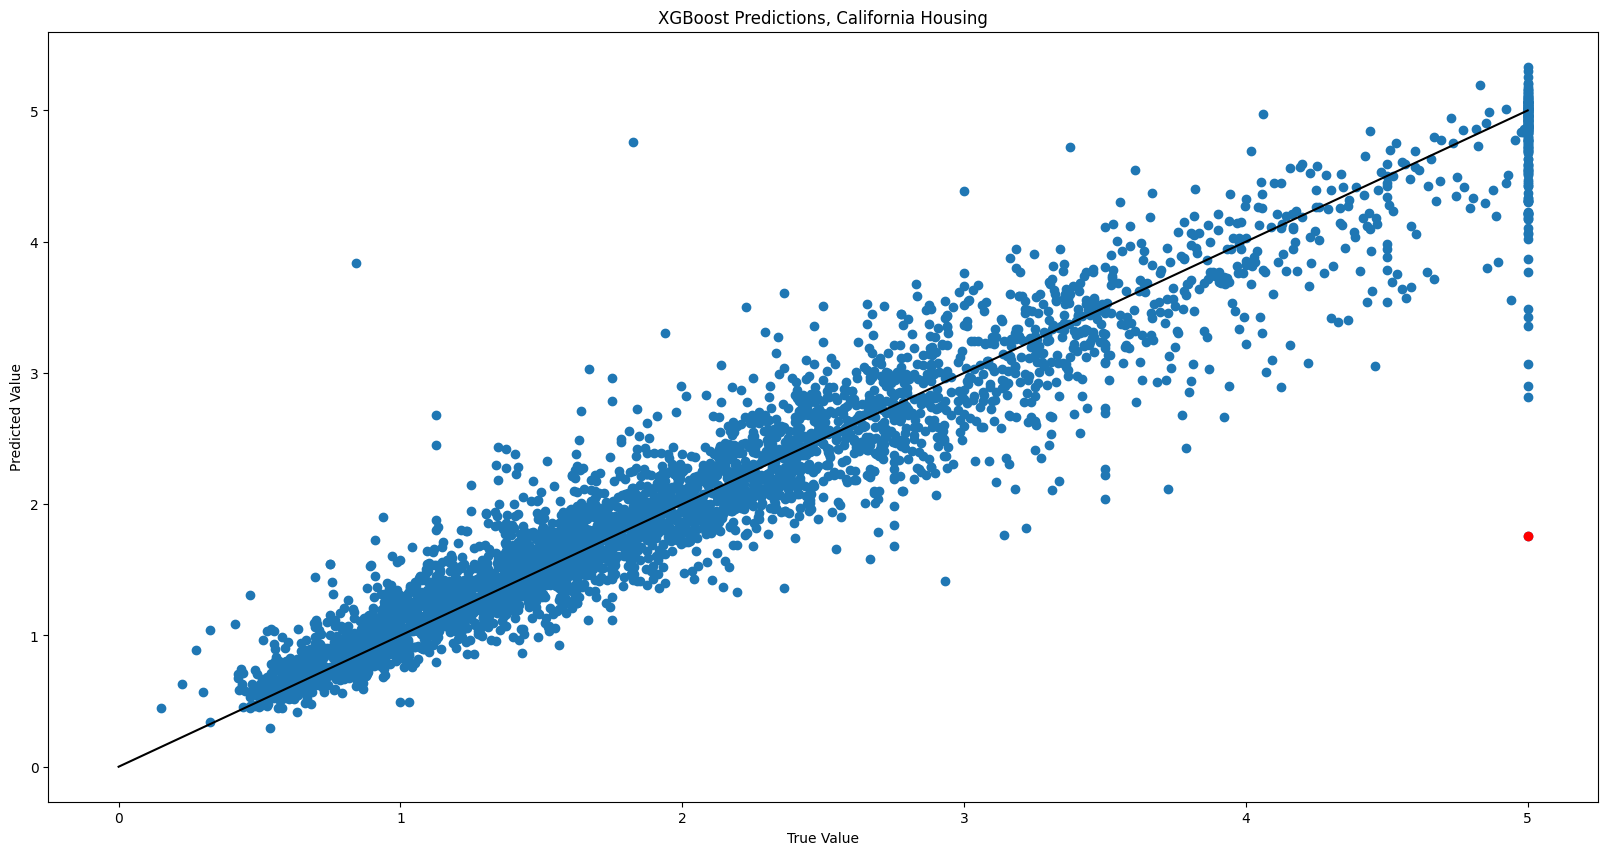

In [32]:
plt.figure(figsize=(20,10))
plt.scatter(y_test, predictions)
plt.scatter(y_test['MedHouseVal'].iloc[worst], predictions[worst], color='r')
plt.plot([0,5], [0,5], color='k')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.title("XGBoost Predictions, California Housing")
plt.show()

In [33]:
point_to_explain = X_test.iloc[worst]
point_to_explain

MedInc           0.499900
HouseAge        29.000000
AveRooms         2.373272
AveBedrms        1.055300
Population    2690.000000
AveOccup        12.396313
Latitude        34.020000
Longitude     -118.280000
Name: 4861, dtype: float64

In [34]:
prediction = xgb_model.predict(point_to_explain.to_numpy().reshape(1, -1))
print(f"Prediction: {prediction}")
print(f"True: {y_test.iloc[worst].squeeze()}")

Prediction: [1.7582973]
True: 5.00001


Let's find out why this point is behaving so poorly in predictive terms.

We'll start by using LIME to acess the feature importances.

## LIME

We start by preparing our model to be used by TrustyAI by wrapping the prediction endpoint, `xgb_model.predict` in the TrustyAI `Model` class.
This `Model` class takes care of all the plumbing required to run explainers on a black-box model.

In [35]:
trustyai_model = Model(xgb_model.predict, dataframe_input=True, output_names=['MedHouseVal'])

In [36]:
lime_explanation = lime.explain(inputs=point_to_explain, outputs=prediction, model=trustyai_model)

In [37]:
lime_explanation.as_dataframe()['MedHouseVal']

,Feature,Value,Saliency,Confidence
0,Population,2690.000000,1.249507,0.0
1,HouseAge,29.000000,1.252105,0.0
2,Longitude,-118.280000,-0.609644,0.0
3,MedInc,0.499900,-0.383393,0.0
4,Latitude,34.020000,-0.315504,0.0
5,AveRooms,2.373272,-0.338047,0.0


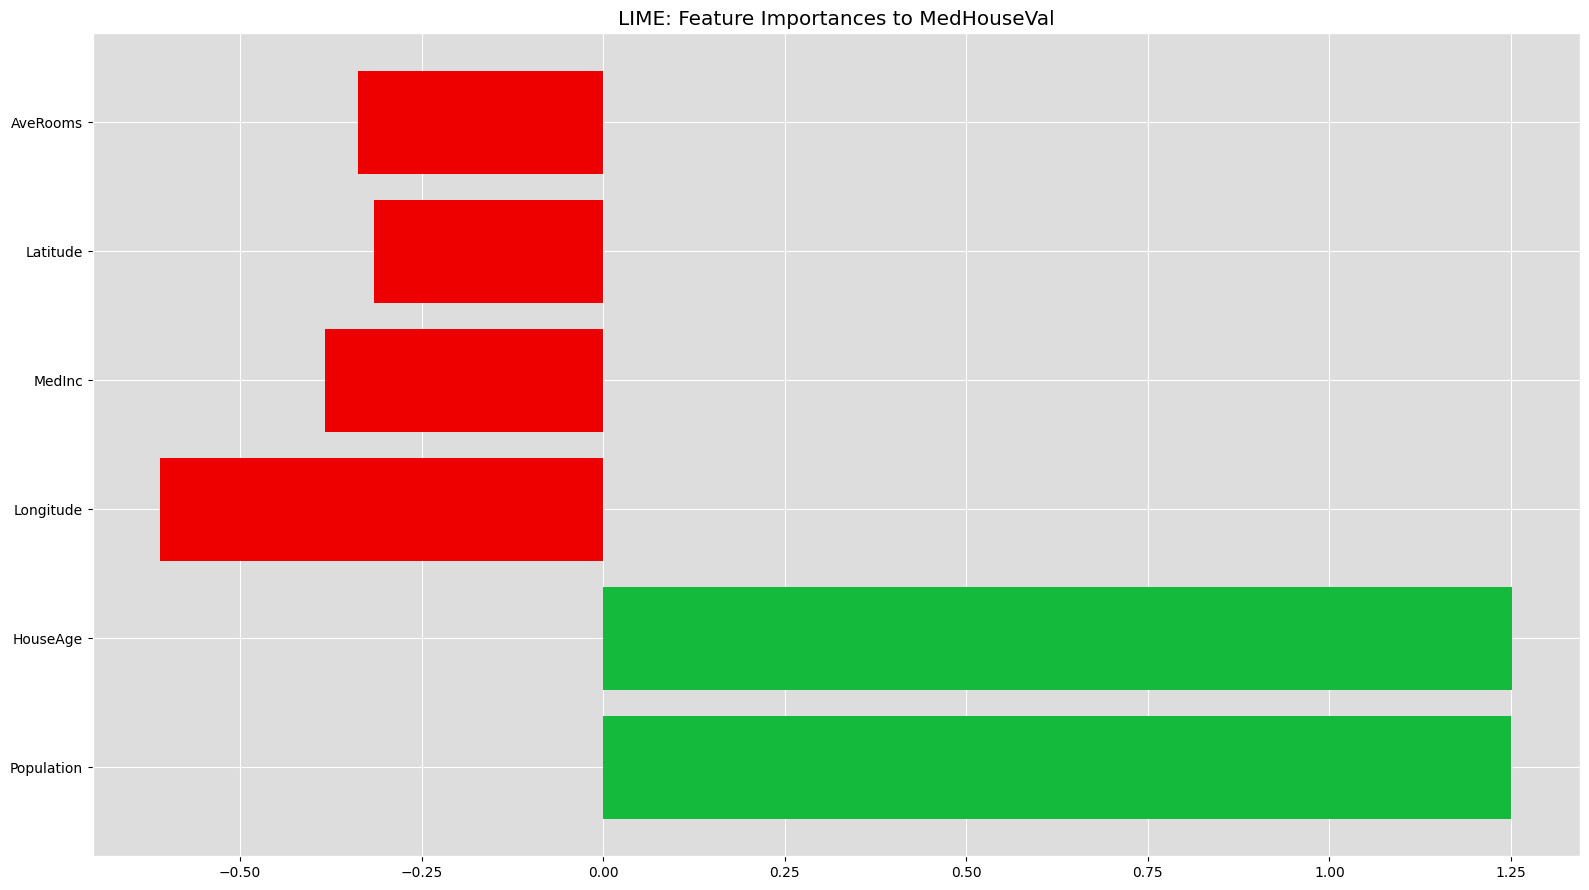

In [38]:
lime_explanation.plot('MedHouseVal')

(0.0, 8000.0)

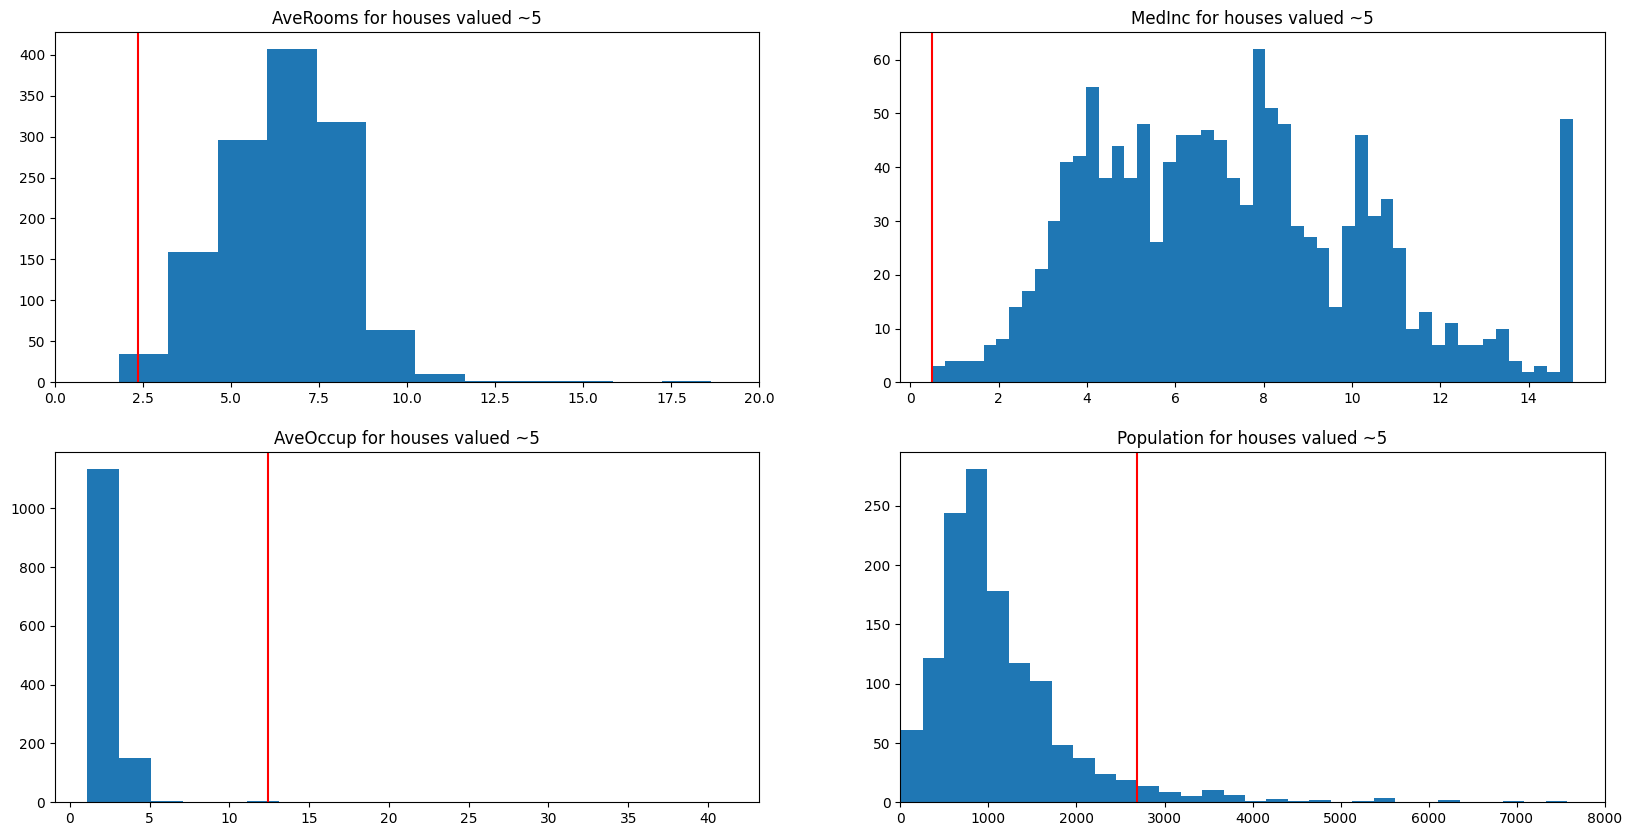

In [39]:
df_max_value = X[y.MedHouseVal.between(4.5, 5.5)]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.hist(df_max_value.AveRooms, bins=100)
ax1.axvline(x = point_to_explain.AveRooms, c="r")
ax1.set_title("AveRooms for houses valued ~5")
ax1.set_xlim(0, 20)
ax2.hist(df_max_value.MedInc, bins=50)
ax2.axvline(x = point_to_explain.MedInc, c="r")
ax2.set_title("MedInc for houses valued ~5")
ax3.hist(df_max_value.AveOccup, bins=20)
ax3.axvline(x = point_to_explain.AveOccup, c="r")
ax3.set_title("AveOccup for houses valued ~5")
ax4.hist(df_max_value.Population, bins=50)
ax4.axvline(x = point_to_explain.Population, c="r")
ax4.set_title("Population for houses valued ~5")
ax4.set_xlim(0, 8000)

## SHAP

In [40]:
shap = SHAPExplainer(background=X_train[:100])

In [41]:
shap_explanations = shap.explain(inputs=point_to_explain, 
                                 outputs=prediction,
                                 model=trustyai_model)

In [42]:
shap_explanations.as_html()['MedHouseVal']

,Feature,Value,Mean Background Value,SHAP Value,Confidence
0,Background,nan,nan,2.213838,nan
1,MedInc,0.499900,4.180259,-0.185947,0.072070
2,HouseAge,29.000000,29.710000,-0.016088,0.072070
3,AveRooms,2.373272,5.701355,0.032975,0.072070
4,AveBedrms,1.055300,1.137595,-0.002570,0.072070
5,Population,2690.000000,1504.930000,0.120333,0.072070
6,AveOccup,12.396313,2.891669,-0.290723,0.072070
7,Latitude,34.020000,35.121800,0.268285,0.072070
8,Longitude,-118.280000,-119.024000,-0.381806,0.190679


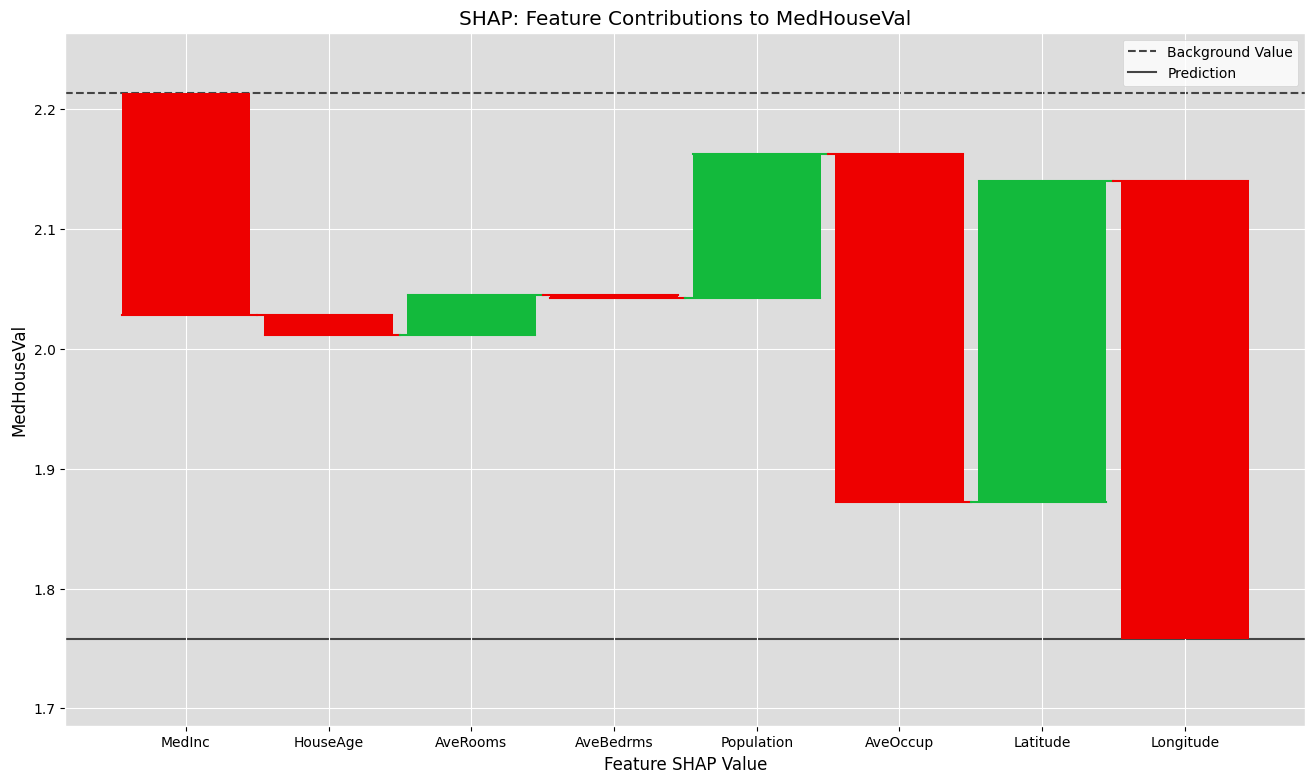

In [43]:
shap_explanations.plot()

## Counterfactuals

### Unconstrained search

In [44]:
feature_domains = [feature_domain(domain) for domain in [
    (0.0, 1000.0), # MedInc
    (1.0, 1000.0), # HouseAge
    (1, 20), # AveRooms
    (1, 20), # AveBedrms
    (1.0, 10_000.0), # Population
    (1.0, 50.0), # AveOccup
    (-90.0, 90.0), # Latitude
    (-180.0, 180.0), # Longitude
]]


In [45]:
goal = [output("MedHouseVal", "number", 5.0)]

In [46]:
cf_explanation = counterfactual.explain(inputs=point_to_explain, goal=goal, feature_domains=feature_domains, model=trustyai_model)

In [47]:
cf_explanation.as_dataframe()

,features,proposed,original,constrained,difference
0,MedInc,0.499900,0.499900,False,0.000000
1,HouseAge,29.000000,29.000000,False,0.000000
2,AveRooms,2.373272,2.373272,False,0.000000
3,AveBedrms,1.055300,1.055300,False,0.000000
4,Population,2690.000000,2690.000000,False,0.000000
5,AveOccup,1.350853,12.396313,False,-11.045460
6,Latitude,32.667780,34.020000,False,-1.352220
7,Longitude,-124.374857,-118.280000,False,-6.094857


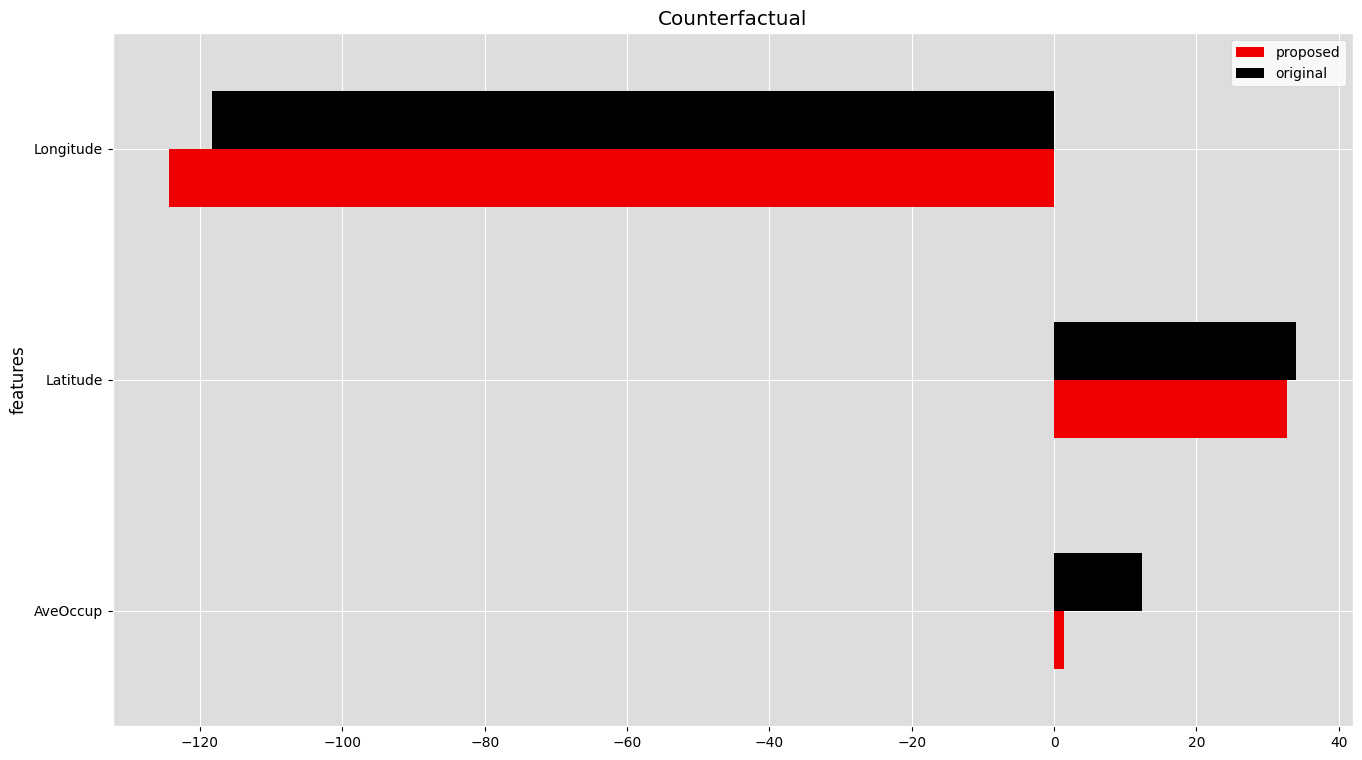

In [48]:
cf_explanation.plot()

In [49]:
trustyai_model(cf_explanation.proposed_features_dataframe)

array([5.0016675], dtype=float32)

### Constrained search

In [50]:
feature_domains = [feature_domain(domain) if domain else None for domain in [
    (0.0, 1000.0), # MedInc
    None, # HouseAge
    (1, 20), # AveRooms
    (1, 20), # AveBedrms
    None, # Population
    (1.0, 50.0), # AveOccup
    None, # Latitude
    None, # Longitude
]]

In [51]:
cf_explanation = counterfactual.explain(inputs=point_to_explain, goal=goal, feature_domains=feature_domains, model=trustyai_model)

In [52]:
cf_explanation.as_html()

,features,proposed,original,constrained,difference
0,MedInc,8.031379,0.499900,False,7.531479
1,HouseAge,29.000000,29.000000,True,0.000000
2,AveRooms,7.897794,2.373272,False,5.524522
3,AveBedrms,1.055300,1.055300,False,0.000000
4,Population,2690.000000,2690.000000,True,0.000000
5,AveOccup,2.538972,12.396313,False,-9.857342
6,Latitude,34.020000,34.020000,True,0.000000
7,Longitude,-118.280000,-118.280000,True,0.000000


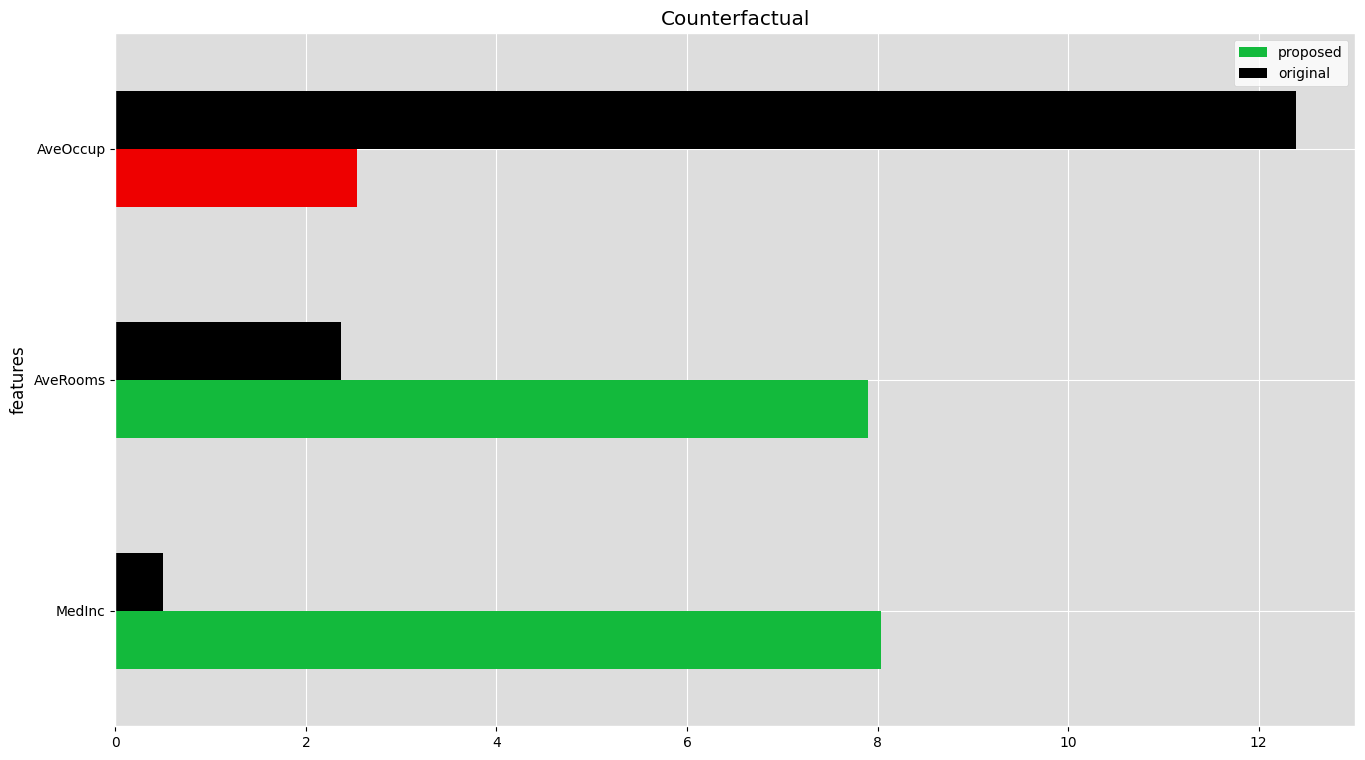

In [53]:
cf_explanation.plot()

In [54]:
new_inputs = cf_explanation.proposed_features_dataframe
prediction = trustyai_model(new_inputs)
prediction

array([4.9947243], dtype=float32)

# Visualisation

In [55]:
from trustyai.utils.tyrus import Tyrus
import os

tyrus = Tyrus(
    model=trustyai_model,
    inputs=new_inputs,
    outputs=pd.DataFrame().from_dict({'MedHouseVal': [prediction[0]]}),
    background=X_train[:100]
)

In [56]:
tyrus.run()

Tabs(id='1221', ...)

# Fairness metrics

In [60]:
nobias = pd.read_csv("data/income-unbiased.zip", index_col=False)

In [61]:
nobias

,age,race,gender,income
0,13,0,0,0
1,65,7,0,1
2,71,6,1,0
3,38,1,1,1
4,42,0,0,1
...,...,...,...,...
9995,20,5,1,0
9996,34,2,1,0
9997,25,2,1,1
9998,73,5,1,1


## Demographic Parity


_Demographic Parity_ provides a measure of imbalances in positive and negative outcomes between priveleged and unprivileged groups.

Taking the previous data as an example, we would use Demographic Parity metrics to measure if (for instance), the `income` is predicted to be above or below $50k regardless of race or gender.


### Statistical Parity Difference

The _Statistical Parity Difference (SPD)_  is the difference in the probability of prediction between the privileged and unprivileged groups. Typically:

- $SPD=0$ means that the model is behaving fairly in regards of the selected attribute (e.g. race, gender)
- Values between $-0.1<SPD<0.1$ mean that the model is _reasonably fair_ and the score can be attributed to other factors, such as sample size.
- An $SPD$ outside this range would be an indicator of an _unfair_ model relatively to the protected attributes.
    - A *negative* value of statistical parity difference indicates that the unprivileged group is at a disadvantage
    - A *positive* value indicates that the privileged group is at a disadvantage.

The formal definition of $SPD$ is

$$
SPD=p(\hat{y}=1|\mathcal{D}_u)-p(\hat{y}=1|\mathcal{D}_p)
$$

where $\hat{y}=1$ is the favorable outcome and $\mathcal{D}_u$, $\mathcal{D}_p$ are respectively the privileged and unpriviledge group data.


#### Unbiased dataset

In [62]:
nobias.groupby(['gender', 'income'])['income'].count()

gender  income
0       0         1466
        1          548
1       0         5842
        1         2144
Name: income, dtype: int64

<AxesSubplot:xlabel='gender'>

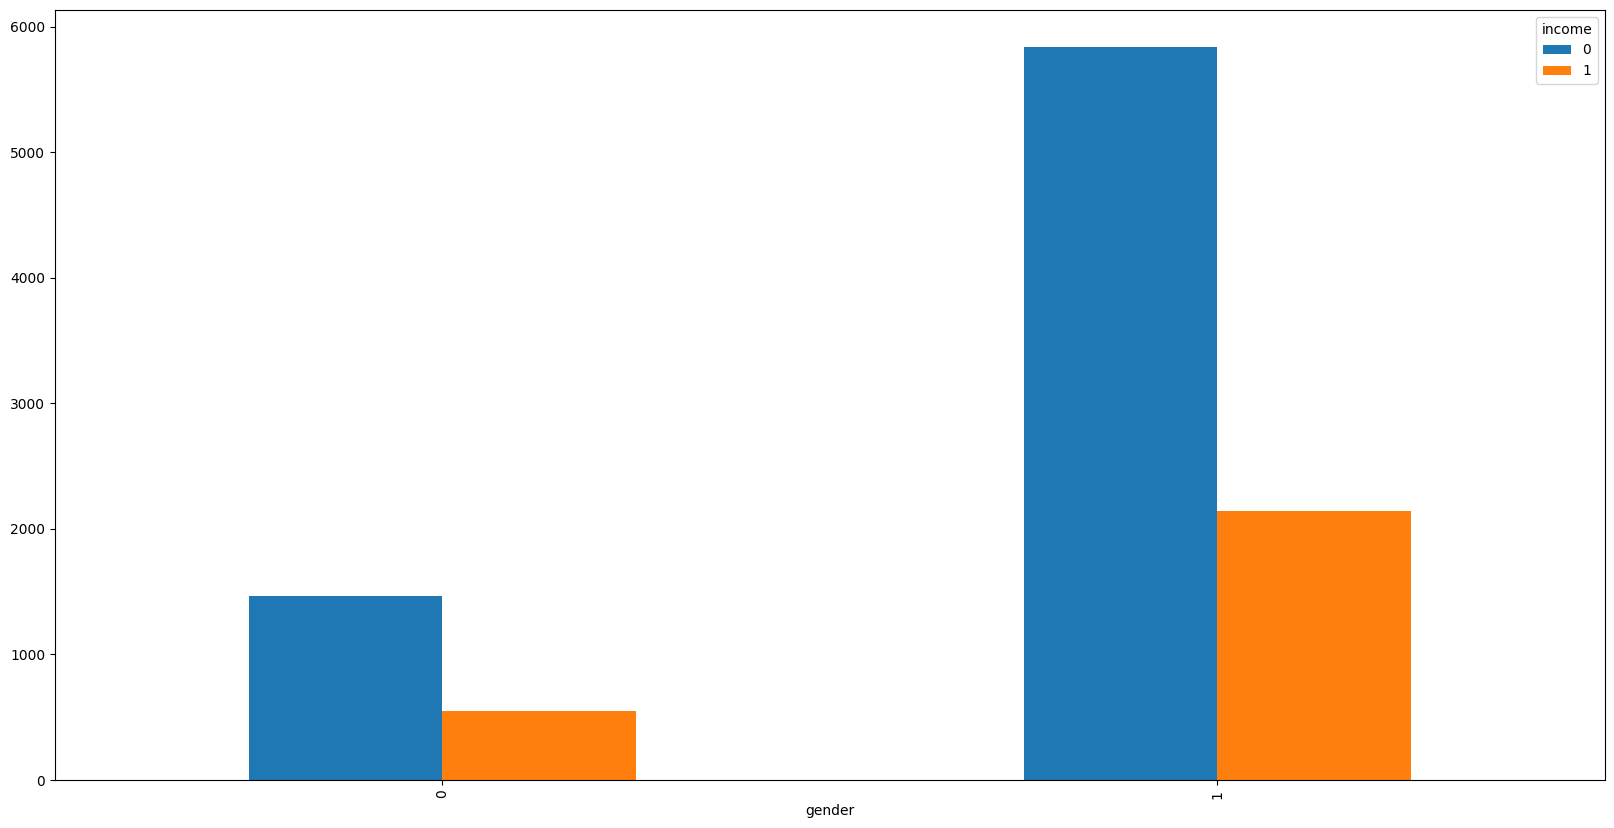

In [66]:
nobias.groupby(['gender', 'income'])['income'].count().unstack().plot.bar(figsize=(20,10))

In [85]:
from trustyai.metrics.fairness.group import statistical_parity_difference, \
    disparate_impact_ratio, average_odds_difference, average_predictive_value_difference

nobias_privileged = nobias[nobias.gender == 1]
nobias_unprivileged = nobias[nobias.gender == 0]
favorable = output("income", dtype="number", value=1)
score = statistical_parity_difference(privileged=nobias_privileged,
                                      unprivileged=nobias_unprivileged,
                                      favorable=[favorable])

In [69]:
print(f"Statistical Parity Difference = {score}")

Statistical Parity Difference = 0.0036255104824703954


We can see that the $SPD$ for this dataset is between the $[-0.1, 0.1]$ threshold, which classifies the model as _reasonably fair_.

In [70]:
bias = pd.read_csv("data/income-biased.zip", index_col=False)
bias.groupby(['gender', 'income'])['income'].count()

gender  income
0       0         1772
        1          242
1       0         5775
        1         2211
Name: income, dtype: int64

<AxesSubplot:xlabel='gender'>

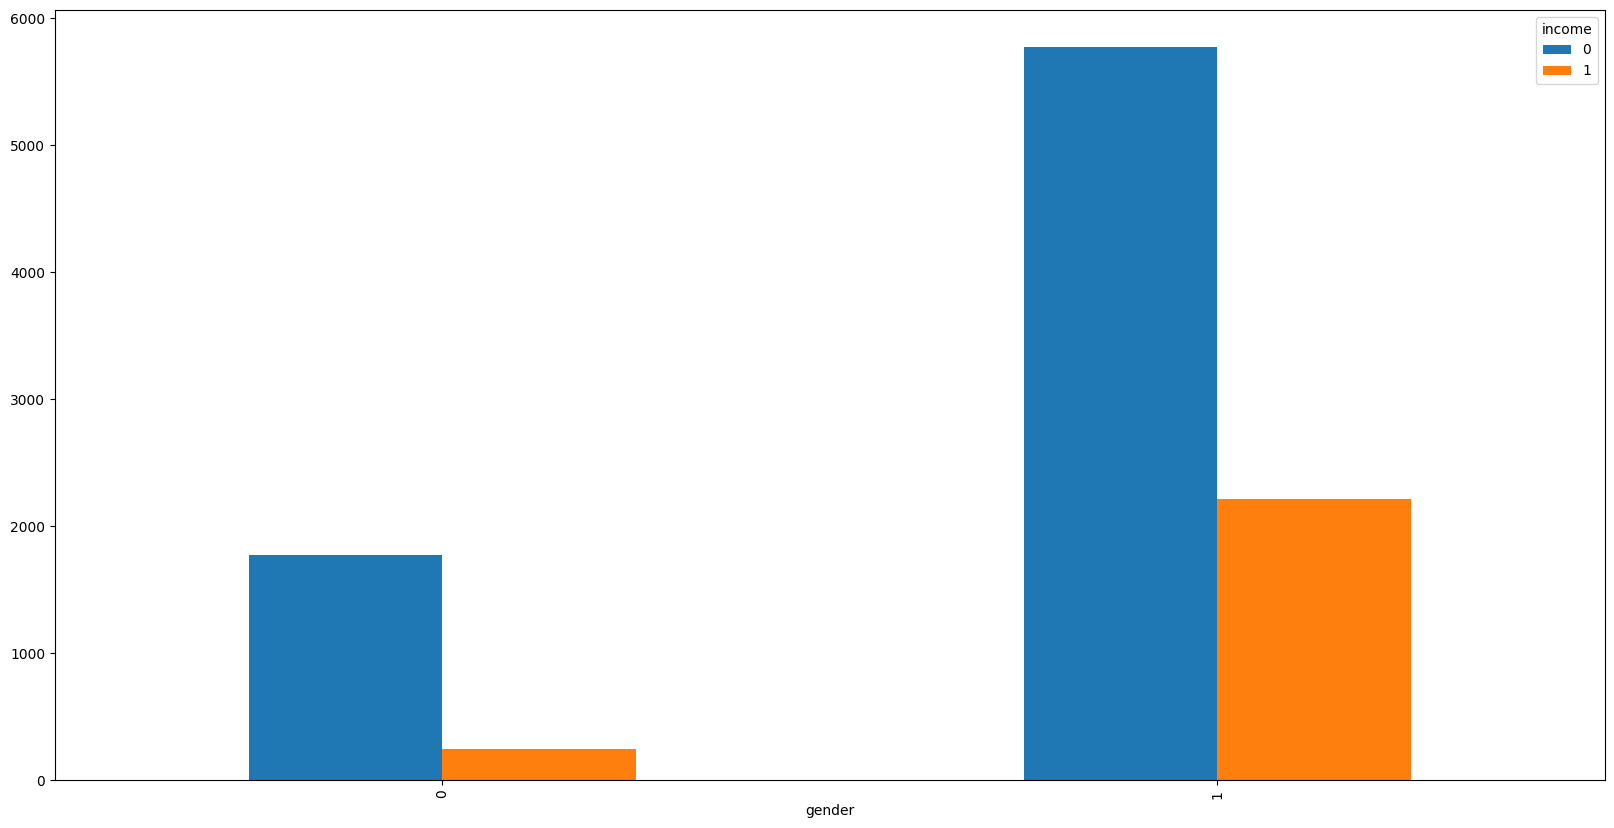

In [71]:
bias.groupby(['gender', 'income'])['income'].count().unstack().plot.bar(figsize=(20,10))

In [72]:
bias_privileged = bias[bias.gender == 1]
bias_unprivileged = bias[bias.gender == 0]

score = statistical_parity_difference(privileged=bias_privileged,
                                      unprivileged=bias_unprivileged,
                                      favorable=[favorable])

In [73]:
print(f"Statistical Parity Difference = {score}")

Statistical Parity Difference = -0.15670061634672994


This dataset, as expected, is outside the $[-0.1, 0.1]$ threshold, which classifies the model as _unfair_.
In addiction, the negative score indicates that the unprivileged group (in our example, `gender = 0`) is the one in disadvantage for this particular outcome.

### Disparate impact ratio


Similarly to the _Statistical Parity Difference_, the _Disparate Impact Ratio (DIR)_ measures imbalances in positive outcome predictions across privliged and unpriviliged groups.
Instead of calculating the difference, this metric calculates the ration of such selection rates.Typically:

- $DIR=1$ means that the model is fair with regards to the protected attribute.
- $0.8<DIR<1.2$ means that the model is _reasonably fair_.

The formal definition of the _Disparate Impact Ratio_ is:

$$
DIR=\dfrac{p(\hat{y}=1|\mathcal{D}_u)}{p(\hat{y}=1|\mathcal{D}_p)}
$$


In [77]:
score = disparate_impact_ratio(privileged=nobias_privileged,
                               unprivileged=nobias_unprivileged,
                                      favorable=[favorable])

In [78]:
print(f"Disparate Impact Ratio = {score}")

Disparate Impact Ratio = 1.0135043501459928


In [79]:
score = disparate_impact_ratio(privileged=bias_privileged,
                               unprivileged=bias_unprivileged,
                                      favorable=[favorable])

In [80]:
print(f"Disparate Impact Ratio = {score}")

Disparate Impact Ratio = 0.43400672901628895


### Average Odds Difference

_Average Odds Difference_ measures the difference between the True Positive Rates ($TPR$) for the privileged and unprivileged groups, and the False Positive Rates ($FPR$) for the same groups. Formally, the definition is:

$$
AOD=\dfrac{(FPR_{u}-FPR_{p})+(TPR_{u}-TPR_{p})}{2}
$$

Typically:

- A fair model will have $AOD=0$
- A positive value indicates the model benefits the unprivileged group
- A negative value indicates the model benefits the privileged group

In [82]:
score = average_odds_difference(test=bias,
                                truth=nobias,
                                privilege_columns=["gender"],
                                privilege_values=[1], # privileged gender value, gender = 1
                                positive_class=[1]) # positive class, income = 1

In [83]:
print(f"Average Odds Difference = {score}")

Average Odds Difference = -0.23806418646688987


As we can see, the $AOD$ indicates that the privileged group (`gender = 1`) is at an advantage in this model.

### Average Predictive Value Difference

The _Average Predictive Value Difference (APVD)_ measures the difference in the average accuracy of predicted values between the privileged and unprivileged groups in a dataset. 

In [86]:
score = average_predictive_value_difference(test=bias,
                                truth=nobias,
                                privilege_columns=["gender"],
                                privilege_values=[1],
                                positive_class=[1])
print(score)

-0.04841289822293428
